In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Mon Jan 29 01:25:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P2              45W / 215W |   1327MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [75]:
# del model
# del model
# del optimizer
# del scheduler
# del losses
# del transform
torch.cuda.empty_cache()
gc.collect()

1495

In [ ]:
%reset -f

In [3]:
import gc
import os
os.chdir('IConNet')

In [4]:
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
from torchaudio.datasets import SPEECHCOMMANDS


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, data_dir, download=False, subset: str = None):
        super().__init__(data_dir, download=download)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [9]:
data_dir = '../data/'
val_set = SubsetSC(data_dir, download=False, subset="validation")
waveform, sample_rate, label, speaker_id, utterance_number = val_set[0]

Shape of waveform: torch.Size([1, 15018])
Sample rate of waveform: 16000


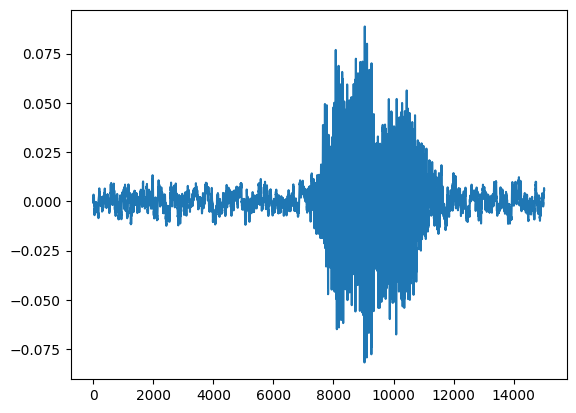

In [10]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [11]:
# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC(data_dir, download=False, subset="training")
test_set = SubsetSC(data_dir, download=False, subset="testing")

In [12]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [59]:
# new_sample_rate = 8000
# transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate, dtype=torch.float32)
# transformed = transform(waveform)

# ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 64

if device == "cuda":
    num_workers = 1
    pin_memory = False # True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [25]:
from IConNet.signal import visualize_window, general_cosine_window

In [33]:
from IConNet.FIRConv import Downsample2
from einops import rearrange, reduce

class M9(nn.Module):
    def __init__(self, n_input=1, n_output=35, 
                 stride=16, n_channel=128, eps=1e-12):
        super().__init__()
        self.conv1 = Downsample2(n_input, n_channel, 
                                kernel_size=511, stride=16, window_k=2)
        self.conv3 = Downsample2(n_channel, n_channel, 
                                kernel_size=127, stride=4, window_k=3)
        self.layer_norm = nn.LayerNorm(3*n_channel)
        self.eps = eps
        self.cls_head = nn.Sequential(
            nn.Linear(3*n_channel, 2*n_channel),
            nn.PReLU(2*n_channel),
            nn.Linear(2*n_channel, n_output)
        )

        self.act = NLReLU(beta=1.0)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.act(x1)
        x3 = self.act(self.conv3(x2))
        x1 = reduce(x1, 'b c n -> b () c', 'mean')
        x2 = reduce(x2, 'b c n -> b () c', 'mean')
        x3 = reduce(x3, 'b c n -> b () c', 'mean')
        x = torch.cat([x1, x2, x3], dim=-1)
        x = rearrange(x, 'b 1 c -> b c')
        x = self.layer_norm(x)
        x = self.cls_head(x)
        return x 

class NLReLU(nn.Module):
    def __init__(self, beta=1.):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        return nl_relu(x, self.beta)
        
def nl_relu(x, beta=1.):
    return torch.log(1 + beta * F.relu(x)) 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = M9(n_input=1, n_output=len(labels))
print(model)

print("Number of parameters: %s" % count_parameters(model))

M9(
  (conv1): Downsample2()
  (conv3): Downsample2()
  (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (cls_head): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): PReLU(num_parameters=256)
    (2): Linear(in_features=256, out_features=35, bias=True)
  )
  (act): NLReLU()
)
Number of parameters: 191011


In [34]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [28]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # data = transform(data)
        output = model(data)
        loss = F.cross_entropy(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()

        # update progress bar
        pbar.update(pbar_update)
    torch.cuda.empty_cache()
    acc = correct / len(test_loader.dataset)
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * acc:.0f}%)\n")
    return acc

In [36]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                       | 0.0026702269692923898/10 [00:00<25:03, 150.41s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.563543


  0%|                         | 0.029372496662216304/10 [00:02<14:12, 85.53s/it]

Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.243939


  1%|▏                         | 0.05607476635514024/10 [00:05<14:11, 85.58s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.124090


  1%|▏                         | 0.08277703604806397/10 [00:07<14:07, 85.45s/it]

Train Epoch: 1 [7680/84843 (9%)]	Loss: 3.128241


  1%|▎                         | 0.10947930574098763/10 [00:09<14:14, 86.36s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.860138


  1%|▎                         | 0.13618157543391152/10 [00:12<14:20, 87.25s/it]

Train Epoch: 1 [12800/84843 (15%)]	Loss: 2.820426


  2%|▍                         | 0.16288384512683574/10 [00:14<14:03, 85.74s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.312823


  2%|▍                         | 0.18958611481975995/10 [00:16<14:17, 87.40s/it]

Train Epoch: 1 [17920/84843 (21%)]	Loss: 2.720238


  2%|▌                         | 0.21628838451268417/10 [00:19<13:55, 85.37s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.277913


  2%|▋                          | 0.2429906542056084/10 [00:21<14:06, 86.80s/it]

Train Epoch: 1 [23040/84843 (27%)]	Loss: 2.753640


  3%|▋                          | 0.2696929238985326/10 [00:23<14:09, 87.31s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.712713


  3%|▊                         | 0.29639519359145683/10 [00:26<13:54, 85.96s/it]

Train Epoch: 1 [28160/84843 (33%)]	Loss: 2.115087


  3%|▊                         | 0.32309746328438105/10 [00:28<13:51, 85.91s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 2.487189


  3%|▉                         | 0.34979973297730527/10 [00:30<13:51, 86.20s/it]

Train Epoch: 1 [33280/84843 (39%)]	Loss: 2.112319


  4%|█                          | 0.3765020026702295/10 [00:33<13:54, 86.69s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 2.279815


  4%|█                          | 0.4032042723631537/10 [00:35<13:48, 86.37s/it]

Train Epoch: 1 [38400/84843 (45%)]	Loss: 2.137388


  4%|█▏                         | 0.4299065420560779/10 [00:37<14:25, 90.41s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.938318


  5%|█▏                        | 0.45660881174900214/10 [00:40<14:12, 89.36s/it]

Train Epoch: 1 [43520/84843 (51%)]	Loss: 1.899548


  5%|█▎                        | 0.48331108144192636/10 [00:42<13:38, 86.01s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.791202


  5%|█▍                         | 0.5100133511348506/10 [00:44<13:38, 86.25s/it]

Train Epoch: 1 [48640/84843 (57%)]	Loss: 1.930627


  5%|█▍                         | 0.5367156208277748/10 [00:47<15:23, 97.58s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.873643


  6%|█▌                         | 0.563417890520699/10 [00:49<16:05, 102.26s/it]

Train Epoch: 1 [53760/84843 (63%)]	Loss: 2.680866


  6%|█▌                         | 0.5901201602136232/10 [00:52<14:23, 91.80s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.943096


  6%|█▋                         | 0.6168224299065475/10 [00:54<14:25, 92.22s/it]

Train Epoch: 1 [58880/84843 (69%)]	Loss: 1.887371


  6%|█▋                         | 0.6435246995994717/10 [00:57<13:44, 88.12s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.901950


  7%|█▊                         | 0.6702269692923959/10 [00:59<13:17, 85.52s/it]

Train Epoch: 1 [64000/84843 (75%)]	Loss: 1.556323


  7%|█▉                         | 0.6969292389853201/10 [01:01<13:17, 85.74s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.603027


  7%|█▉                         | 0.7236315086782443/10 [01:04<13:24, 86.78s/it]

Train Epoch: 1 [69120/84843 (81%)]	Loss: 2.104764


  8%|██                         | 0.7503337783711685/10 [01:06<13:25, 87.08s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.438159


  8%|██                         | 0.7770360480640928/10 [01:08<13:32, 88.07s/it]

Train Epoch: 1 [74240/84843 (87%)]	Loss: 1.462340


  8%|██▎                         | 0.803738317757017/10 [01:11<13:58, 91.17s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.190713


  8%|██▏                        | 0.8304405874499412/10 [01:13<13:14, 86.64s/it]

Train Epoch: 1 [79360/84843 (94%)]	Loss: 1.577806


  9%|██▎                        | 0.8571428571428654/10 [01:15<14:26, 94.76s/it]

Train Epoch: 1 [81920/84843 (97%)]	Loss: 1.760769


  9%|██▍                        | 0.8838451268357896/10 [01:18<13:36, 89.61s/it]

Train Epoch: 1 [84480/84843 (100%)]	Loss: 1.765949


 10%|██▋                        | 1.0020026702269793/10 [01:23<07:07, 47.51s/it]


Test Epoch: 1	Accuracy: 6206/11005 (56%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.252773


 10%|██▊                        | 1.0293724966622266/10 [01:25<12:40, 84.82s/it]

Train Epoch: 2 [2560/84843 (3%)]	Loss: 1.503099


 11%|██▊                        | 1.0560747663551509/10 [01:27<12:54, 86.62s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.261676


 11%|███                         | 1.082777036048075/10 [01:30<13:07, 88.32s/it]

Train Epoch: 2 [7680/84843 (9%)]	Loss: 1.492469


 11%|██▉                        | 1.1094793057409993/10 [01:32<13:04, 88.22s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.338274


 11%|███                        | 1.1361815754339235/10 [01:35<12:45, 86.37s/it]

Train Epoch: 2 [12800/84843 (15%)]	Loss: 1.197356


 12%|███▏                       | 1.1628838451268477/10 [01:37<13:03, 88.61s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.425870


 12%|███▎                        | 1.189586114819772/10 [01:39<13:05, 89.21s/it]

Train Epoch: 2 [17920/84843 (21%)]	Loss: 1.188042


 12%|███▎                       | 1.2162883845126962/10 [01:42<12:57, 88.56s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.451686


 12%|███▏                      | 1.2429906542056204/10 [01:44<14:38, 100.30s/it]

Train Epoch: 2 [23040/84843 (27%)]	Loss: 1.470220


 13%|███▍                       | 1.2696929238985446/10 [01:47<14:28, 99.49s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.870850


 13%|███▌                       | 1.2963951935914688/10 [01:49<12:33, 86.53s/it]

Train Epoch: 2 [28160/84843 (33%)]	Loss: 1.218728


 13%|███▋                        | 1.323097463284393/10 [01:52<12:46, 88.32s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.240087


 13%|███▋                       | 1.3497997329773173/10 [01:54<12:26, 86.35s/it]

Train Epoch: 2 [33280/84843 (39%)]	Loss: 1.339927


 14%|███▋                       | 1.3765020026702415/10 [01:56<12:25, 86.39s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.907925


 14%|███▊                       | 1.4032042723631657/10 [01:59<12:25, 86.73s/it]

Train Epoch: 2 [38400/84843 (45%)]	Loss: 0.925889


 14%|████▏                        | 1.42990654205609/10 [02:01<12:20, 86.36s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.762042


 15%|███▉                       | 1.4566088117490141/10 [02:03<12:17, 86.38s/it]

Train Epoch: 2 [43520/84843 (51%)]	Loss: 0.916899


 15%|████                       | 1.4833110814419384/10 [02:05<12:17, 86.59s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.716992


 15%|████                       | 1.5100133511348626/10 [02:08<12:18, 86.96s/it]

Train Epoch: 2 [48640/84843 (57%)]	Loss: 0.953408


 15%|████▏                      | 1.5367156208277868/10 [02:10<12:12, 86.59s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.984894


 16%|████▍                       | 1.563417890520711/10 [02:13<12:36, 89.62s/it]

Train Epoch: 2 [53760/84843 (63%)]	Loss: 0.718281


 16%|████▎                      | 1.5901201602136352/10 [02:15<12:17, 87.73s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.884456


 16%|████▎                      | 1.6168224299065594/10 [02:17<12:04, 86.44s/it]

Train Epoch: 2 [58880/84843 (69%)]	Loss: 0.724398


 16%|████▍                      | 1.6435246995994837/10 [02:20<12:03, 86.53s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.839239


 17%|████▌                      | 1.6702269692924079/10 [02:22<12:01, 86.56s/it]

Train Epoch: 2 [64000/84843 (75%)]	Loss: 0.753517


 17%|████▊                       | 1.696929238985332/10 [02:24<12:00, 86.79s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.984222


 17%|████▋                      | 1.7236315086782563/10 [02:26<12:03, 87.41s/it]

Train Epoch: 2 [69120/84843 (81%)]	Loss: 0.899175


 18%|████▋                      | 1.7503337783711805/10 [02:29<11:59, 87.21s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 1.119735


 18%|████▊                      | 1.7770360480641048/10 [02:31<11:51, 86.57s/it]

Train Epoch: 2 [74240/84843 (87%)]	Loss: 0.637034


 18%|█████                       | 1.803738317757029/10 [02:33<11:54, 87.14s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.747665


 18%|████▉                      | 1.8304405874499532/10 [02:36<11:49, 86.82s/it]

Train Epoch: 2 [79360/84843 (94%)]	Loss: 1.000477


 19%|█████                      | 1.8571428571428774/10 [02:38<11:47, 86.90s/it]

Train Epoch: 2 [81920/84843 (97%)]	Loss: 0.886452


 19%|█████                      | 1.8838451268358016/10 [02:41<12:53, 95.35s/it]

Train Epoch: 2 [84480/84843 (100%)]	Loss: 1.094435


 20%|█████▍                     | 2.0013351134846675/10 [02:46<05:38, 42.27s/it]


Test Epoch: 2	Accuracy: 8440/11005 (77%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.635814


 20%|█████▍                     | 2.0293724966622286/10 [02:49<11:42, 88.12s/it]

Train Epoch: 3 [2560/84843 (3%)]	Loss: 0.691858


 21%|█████▊                      | 2.056074766355144/10 [02:51<11:28, 86.68s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.748390


 21%|█████▌                     | 2.0827770360480593/10 [02:53<11:25, 86.55s/it]

Train Epoch: 3 [7680/84843 (9%)]	Loss: 1.044162


 21%|█████▋                     | 2.1094793057409746/10 [02:56<11:27, 87.18s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.922310


 21%|██████▏                      | 2.13618157543389/10 [02:58<11:23, 86.87s/it]

Train Epoch: 3 [12800/84843 (15%)]	Loss: 0.821850


 22%|█████▊                     | 2.1628838451268053/10 [03:00<11:20, 86.85s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.560779


 22%|█████▉                     | 2.1895861148197207/10 [03:03<11:17, 86.79s/it]

Train Epoch: 3 [17920/84843 (21%)]	Loss: 0.563216


 22%|██████▏                     | 2.216288384512636/10 [03:05<11:15, 86.81s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.739735


 22%|██████                     | 2.2429906542055513/10 [03:07<11:34, 89.52s/it]

Train Epoch: 3 [23040/84843 (27%)]	Loss: 0.873207


 23%|██████▏                    | 2.2696929238984667/10 [03:10<11:12, 87.06s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.733809


 23%|██████▍                     | 2.296395193591382/10 [03:12<11:24, 88.88s/it]

Train Epoch: 3 [28160/84843 (33%)]	Loss: 0.931701


 23%|██████▎                    | 2.3230974632842973/10 [03:15<11:28, 89.73s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.361959


 23%|██████▎                    | 2.3497997329772127/10 [03:17<11:41, 91.64s/it]

Train Epoch: 3 [33280/84843 (39%)]	Loss: 0.540448


 24%|██████▋                     | 2.376502002670128/10 [03:19<11:31, 90.72s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.525223


 24%|██████▍                    | 2.4032042723630433/10 [03:22<11:34, 91.40s/it]

Train Epoch: 3 [38400/84843 (45%)]	Loss: 0.918410


 24%|██████▌                    | 2.4299065420559587/10 [03:24<11:10, 88.57s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.781350


 25%|██████▉                     | 2.456608811748874/10 [03:27<10:57, 87.20s/it]

Train Epoch: 3 [43520/84843 (51%)]	Loss: 0.984908


 25%|██████▋                    | 2.4833110814417894/10 [03:29<10:53, 86.93s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 1.115836


 25%|██████▊                    | 2.5100133511347047/10 [03:31<10:52, 87.13s/it]

Train Epoch: 3 [48640/84843 (57%)]	Loss: 0.464403


 25%|███████▎                     | 2.53671562082762/10 [03:34<10:51, 87.27s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.608429


 26%|██████▉                    | 2.5634178905205354/10 [03:36<10:46, 86.94s/it]

Train Epoch: 3 [53760/84843 (63%)]	Loss: 0.633676


 26%|██████▉                    | 2.5901201602134507/10 [03:38<11:36, 94.02s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.759633


 26%|███████▎                    | 2.616822429906366/10 [03:41<11:24, 92.72s/it]

Train Epoch: 3 [58880/84843 (69%)]	Loss: 0.509849


 26%|███████▏                   | 2.6435246995992814/10 [03:43<10:42, 87.27s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.704991


 27%|███████▏                   | 2.6702269692921967/10 [03:46<11:16, 92.23s/it]

Train Epoch: 3 [64000/84843 (75%)]	Loss: 0.635628


 27%|███████▌                    | 2.696929238985112/10 [03:48<11:21, 93.30s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.645282


 27%|███████▎                   | 2.7236315086780274/10 [03:51<10:42, 88.25s/it]

Train Epoch: 3 [69120/84843 (81%)]	Loss: 0.925866


 28%|███████▍                   | 2.7503337783709427/10 [03:53<10:32, 87.19s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.439803


 28%|███████▊                    | 2.777036048063858/10 [03:55<10:28, 87.05s/it]

Train Epoch: 3 [74240/84843 (87%)]	Loss: 0.616519


 28%|███████▌                   | 2.8037383177567734/10 [03:58<10:25, 86.91s/it]

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.857129


 28%|███████▋                   | 2.8304405874496887/10 [04:00<10:41, 89.43s/it]

Train Epoch: 3 [79360/84843 (94%)]	Loss: 0.896528


 29%|███████▉                    | 2.857142857142604/10 [04:02<10:29, 88.19s/it]

Train Epoch: 3 [81920/84843 (97%)]	Loss: 0.576550


 29%|███████▊                   | 2.8838451268355194/10 [04:05<10:28, 88.29s/it]

Train Epoch: 3 [84480/84843 (100%)]	Loss: 0.775049


 30%|████████▋                    | 3.00200267022667/10 [04:10<05:28, 46.89s/it]


Test Epoch: 3	Accuracy: 8819/11005 (80%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.675144


 30%|████████▍                   | 3.029372496661908/10 [04:12<10:54, 93.86s/it]

Train Epoch: 4 [2560/84843 (3%)]	Loss: 0.394603


 31%|████████▎                  | 3.0560747663548233/10 [04:14<10:36, 91.65s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.647399


 31%|████████▎                  | 3.0827770360477387/10 [04:17<11:04, 96.04s/it]

Train Epoch: 4 [7680/84843 (9%)]	Loss: 0.738313


 31%|████████▋                   | 3.109479305740654/10 [04:20<11:00, 95.88s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.841626


 31%|████████▍                  | 3.1361815754335693/10 [04:22<10:59, 96.07s/it]

Train Epoch: 4 [12800/84843 (15%)]	Loss: 0.806445


 32%|████████▌                  | 3.1628838451264847/10 [04:25<10:56, 96.01s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.593083


 32%|█████████▌                    | 3.1895861148194/10 [04:27<10:54, 96.03s/it]

Train Epoch: 4 [17920/84843 (21%)]	Loss: 0.595777


 32%|████████▋                  | 3.2162883845123154/10 [04:30<10:51, 96.00s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.347342


 32%|████████▊                  | 3.2429906542052307/10 [04:33<10:55, 97.08s/it]

Train Epoch: 4 [23040/84843 (27%)]	Loss: 0.596319


 33%|█████████▏                  | 3.269692923898146/10 [04:35<11:07, 99.17s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.598786


 33%|████████▌                 | 3.2963951935910614/10 [04:38<12:44, 114.00s/it]

Train Epoch: 4 [28160/84843 (33%)]	Loss: 0.741006


 33%|████████▋                 | 3.3230974632839767/10 [04:41<11:50, 106.48s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.803731


 33%|█████████▍                  | 3.349799732976892/10 [04:43<10:37, 95.83s/it]

Train Epoch: 4 [33280/84843 (39%)]	Loss: 0.584341


 34%|█████████                  | 3.3765020026698074/10 [04:46<10:34, 95.74s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.319069


 34%|█████████▏                 | 3.4032042723627227/10 [04:48<10:31, 95.74s/it]

Train Epoch: 4 [38400/84843 (45%)]	Loss: 0.806634


 34%|█████████▌                  | 3.429906542055638/10 [04:51<10:43, 97.89s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.697380


 35%|█████████▎                 | 3.4566088117485534/10 [04:54<10:26, 95.77s/it]

Train Epoch: 4 [43520/84843 (51%)]	Loss: 0.596308


 35%|█████████▍                 | 3.4833110814414687/10 [04:56<10:24, 95.82s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.328368


 35%|█████████▊                  | 3.510013351134384/10 [04:59<10:22, 95.90s/it]

Train Epoch: 4 [48640/84843 (57%)]	Loss: 0.437505


 35%|█████████▌                 | 3.5367156208272994/10 [05:01<10:18, 95.76s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.731624


 36%|█████████▎                | 3.5634178905202147/10 [05:04<11:09, 104.06s/it]

Train Epoch: 4 [53760/84843 (63%)]	Loss: 0.658867


 36%|██████████▍                  | 3.59012016021313/10 [05:06<10:16, 96.16s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.537068


 36%|█████████▊                 | 3.6168224299060454/10 [05:09<10:16, 96.59s/it]

Train Epoch: 4 [58880/84843 (69%)]	Loss: 0.880123


 36%|█████████▊                 | 3.6435246995989607/10 [05:12<10:11, 96.19s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.906461


 37%|██████████▎                 | 3.670226969291876/10 [05:14<10:09, 96.24s/it]

Train Epoch: 4 [64000/84843 (75%)]	Loss: 0.518138


 37%|█████████▉                 | 3.6969292389847914/10 [05:17<10:06, 96.22s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.515406


 37%|██████████                 | 3.7236315086777068/10 [05:19<10:03, 96.17s/it]

Train Epoch: 4 [69120/84843 (81%)]	Loss: 0.735325


 38%|██████████▌                 | 3.750333778370622/10 [05:22<10:12, 98.07s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.863030


 38%|██████████▏                | 3.7770360480635374/10 [05:24<10:00, 96.45s/it]

Train Epoch: 4 [74240/84843 (87%)]	Loss: 0.480859


 38%|██████████▎                | 3.8037383177564528/10 [05:27<09:55, 96.18s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.937192


 38%|██████████▋                 | 3.830440587449368/10 [05:30<10:12, 99.29s/it]

Train Epoch: 4 [79360/84843 (94%)]	Loss: 0.539005


 39%|██████████▍                | 3.8571428571422834/10 [05:32<09:58, 97.44s/it]

Train Epoch: 4 [81920/84843 (97%)]	Loss: 0.717142


 39%|██████████▊                 | 3.883845126835199/10 [05:35<09:48, 96.30s/it]

Train Epoch: 4 [84480/84843 (100%)]	Loss: 0.282815


 40%|███████████▏                | 4.000667556741703/10 [05:41<06:07, 61.23s/it]


Test Epoch: 4	Accuracy: 8991/11005 (82%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.416026


 40%|██████████▉                | 4.0293724966616065/10 [05:44<09:35, 96.36s/it]

Train Epoch: 5 [2560/84843 (3%)]	Loss: 0.463038


 41%|███████████▊                 | 4.05607476635454/10 [05:46<09:31, 96.15s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.821465


 41%|███████████▍                | 4.082777036047473/10 [05:49<09:29, 96.19s/it]

Train Epoch: 5 [7680/84843 (9%)]	Loss: 0.693410


 41%|███████████▌                | 4.109479305740406/10 [05:51<09:26, 96.15s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.812311


 41%|███████████▌                | 4.136181575433339/10 [05:54<09:22, 95.92s/it]

Train Epoch: 5 [12800/84843 (15%)]	Loss: 0.424487


 42%|███████████▋                | 4.162883845126272/10 [05:57<09:19, 95.89s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.674249


 42%|███████████▋                | 4.189586114819205/10 [05:59<09:16, 95.70s/it]

Train Epoch: 5 [17920/84843 (21%)]	Loss: 1.081112


 42%|███████████▊                | 4.216288384512138/10 [06:02<09:15, 96.02s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.631204


 42%|███████████▉                | 4.242990654205071/10 [06:04<09:10, 95.71s/it]

Train Epoch: 5 [23040/84843 (27%)]	Loss: 0.392492


 43%|███████████▉                | 4.269692923898004/10 [06:07<09:09, 95.85s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.697272


 43%|███████████▌               | 4.2963951935909375/10 [06:09<09:15, 97.41s/it]

Train Epoch: 5 [28160/84843 (33%)]	Loss: 0.366806


 43%|████████████                | 4.323097463283871/10 [06:12<09:05, 96.03s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.492096


 43%|████████████▏               | 4.349799732976804/10 [06:15<09:12, 97.85s/it]

Train Epoch: 5 [33280/84843 (39%)]	Loss: 0.731536


 44%|████████████▎               | 4.376502002669737/10 [06:17<08:58, 95.79s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.816702


 44%|████████████▊                | 4.40320427236267/10 [06:20<08:57, 96.09s/it]

Train Epoch: 5 [38400/84843 (45%)]	Loss: 0.729293


 44%|████████████▍               | 4.429906542055603/10 [06:22<08:53, 95.83s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.767735


 45%|████████████▍               | 4.456608811748536/10 [06:25<09:00, 97.56s/it]

Train Epoch: 5 [43520/84843 (51%)]	Loss: 0.611804


 45%|████████████▌               | 4.483311081441469/10 [06:27<08:48, 95.76s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.792719


 45%|████████████▋               | 4.510013351134402/10 [06:30<08:47, 96.17s/it]

Train Epoch: 5 [48640/84843 (57%)]	Loss: 0.584885


 45%|████████████▋               | 4.536715620827335/10 [06:33<08:43, 95.91s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.253339


 46%|████████████▎              | 4.5634178905202685/10 [06:35<08:42, 96.08s/it]

Train Epoch: 5 [53760/84843 (63%)]	Loss: 0.659865


 46%|████████████▊               | 4.590120160213202/10 [06:38<08:38, 95.84s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.648204


 46%|████████████▍              | 4.616822429906135/10 [06:40<09:14, 103.03s/it]

Train Epoch: 5 [58880/84843 (69%)]	Loss: 0.689638


 46%|████████████▌              | 4.643524699599068/10 [06:43<09:08, 102.40s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.693292


 47%|█████████████               | 4.670226969292001/10 [06:46<08:32, 96.13s/it]

Train Epoch: 5 [64000/84843 (75%)]	Loss: 0.330237


 47%|█████████████▏              | 4.696929238984934/10 [06:48<08:32, 96.58s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.554754


 47%|█████████████▏              | 4.723631508677867/10 [06:51<08:28, 96.32s/it]

Train Epoch: 5 [69120/84843 (81%)]	Loss: 0.782769


 48%|██████████████▎               | 4.7503337783708/10 [06:54<08:38, 98.70s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.442610


 48%|█████████████▍              | 4.777036048063733/10 [06:56<08:24, 96.65s/it]

Train Epoch: 5 [74240/84843 (87%)]	Loss: 0.621333


 48%|█████████████▍              | 4.803738317756666/10 [06:59<08:17, 95.79s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.554311


 48%|█████████████              | 4.8304405874495995/10 [07:01<08:15, 95.82s/it]

Train Epoch: 5 [79360/84843 (94%)]	Loss: 0.668512


 49%|█████████████▌              | 4.857142857142533/10 [07:04<08:13, 95.93s/it]

Train Epoch: 5 [81920/84843 (97%)]	Loss: 0.381544


 49%|█████████████▏             | 4.883845126835466/10 [07:06<08:51, 103.83s/it]

Train Epoch: 5 [84480/84843 (100%)]	Loss: 0.408590


 50%|██████████████              | 5.001335113484371/10 [07:12<03:53, 46.63s/it]


Test Epoch: 5	Accuracy: 8865/11005 (81%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.948415


 50%|██████████████              | 5.029372496661951/10 [07:14<07:41, 92.92s/it]

Train Epoch: 6 [2560/84843 (3%)]	Loss: 0.380164


 51%|██████████████▏             | 5.056074766354884/10 [07:17<08:02, 97.59s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.441780


 51%|██████████████▏             | 5.082777036047817/10 [07:20<07:53, 96.20s/it]

Train Epoch: 6 [7680/84843 (9%)]	Loss: 0.725679


 51%|██████████████▊              | 5.10947930574075/10 [07:22<07:54, 97.02s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.494908


 51%|█████████████▊             | 5.1361815754336835/10 [07:25<07:45, 95.78s/it]

Train Epoch: 6 [12800/84843 (15%)]	Loss: 0.195049


 52%|██████████████▍             | 5.162883845126617/10 [07:27<07:43, 95.76s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.229971


 52%|███████████████              | 5.18958611481955/10 [07:30<07:40, 95.81s/it]

Train Epoch: 6 [17920/84843 (21%)]	Loss: 0.789349


 52%|██████████████▌             | 5.216288384512483/10 [07:32<07:47, 97.64s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.488816


 52%|██████████████▋             | 5.242990654205416/10 [07:35<07:47, 98.26s/it]

Train Epoch: 6 [23040/84843 (27%)]	Loss: 0.331631


 53%|██████████████▊             | 5.269692923898349/10 [07:38<07:35, 96.37s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.243681


 53%|██████████████▎            | 5.296395193591282/10 [07:40<08:09, 104.07s/it]

Train Epoch: 6 [28160/84843 (33%)]	Loss: 0.668079


 53%|██████████████▎            | 5.323097463284215/10 [07:43<08:00, 102.64s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.773509


 53%|██████████████▉             | 5.349799732977148/10 [07:45<06:40, 86.23s/it]

Train Epoch: 6 [33280/84843 (39%)]	Loss: 0.307612


 54%|██████████████▌            | 5.376502002670081/10 [07:48<08:01, 104.15s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.768049


 54%|██████████████▌            | 5.4032042723630145/10 [07:50<06:43, 87.72s/it]

Train Epoch: 6 [38400/84843 (45%)]	Loss: 0.272671


 54%|██████████████▋            | 5.429906542055948/10 [07:53<07:39, 100.56s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.277869


 55%|███████████████▎            | 5.456608811748881/10 [07:55<07:01, 92.67s/it]

Train Epoch: 6 [43520/84843 (51%)]	Loss: 0.599499


 55%|███████████████▎            | 5.483311081441814/10 [07:58<06:47, 90.23s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.458936


 55%|███████████████▍            | 5.510013351134747/10 [08:00<06:41, 89.43s/it]

Train Epoch: 6 [48640/84843 (57%)]	Loss: 0.289384


 55%|████████████████             | 5.53671562082768/10 [08:02<06:34, 88.43s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.498801


 56%|███████████████▌            | 5.563417890520613/10 [08:05<06:57, 94.09s/it]

Train Epoch: 6 [53760/84843 (63%)]	Loss: 0.522811


 56%|███████████████▋            | 5.590120160213546/10 [08:07<06:22, 86.77s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.658893


 56%|███████████████▋            | 5.616822429906479/10 [08:10<06:32, 89.44s/it]

Train Epoch: 6 [58880/84843 (69%)]	Loss: 0.416982


 56%|███████████████▊            | 5.643524699599412/10 [08:12<06:45, 93.03s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.684721


 57%|███████████████▎           | 5.6702269692923455/10 [08:14<06:20, 87.85s/it]

Train Epoch: 6 [64000/84843 (75%)]	Loss: 0.660336


 57%|███████████████▉            | 5.696929238985279/10 [08:17<06:13, 86.79s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.556146


 57%|████████████████            | 5.723631508678212/10 [08:19<06:27, 90.64s/it]

Train Epoch: 6 [69120/84843 (81%)]	Loss: 0.635664


 58%|████████████████            | 5.750333778371145/10 [08:22<06:14, 88.23s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.448332


 58%|████████████████▏           | 5.777036048064078/10 [08:24<06:21, 90.40s/it]

Train Epoch: 6 [74240/84843 (87%)]	Loss: 0.282688


 58%|████████████████▎           | 5.803738317757011/10 [08:26<06:19, 90.43s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.640951


 58%|████████████████▎           | 5.830440587449944/10 [08:29<06:27, 93.03s/it]

Train Epoch: 6 [79360/84843 (94%)]	Loss: 0.343874


 59%|████████████████▍           | 5.857142857142877/10 [08:31<06:08, 89.06s/it]

Train Epoch: 6 [81920/84843 (97%)]	Loss: 0.381559


 59%|█████████████████            | 5.88384512683581/10 [08:34<06:01, 87.87s/it]

Train Epoch: 6 [84480/84843 (100%)]	Loss: 0.443512


 60%|████████████████▊           | 6.002002670227039/10 [08:39<04:05, 61.36s/it]


Test Epoch: 6	Accuracy: 9002/11005 (82%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.549193


 60%|████████████████▉           | 6.029372496662296/10 [08:41<05:50, 88.24s/it]

Train Epoch: 7 [2560/84843 (3%)]	Loss: 0.610755


 61%|████████████████▉           | 6.056074766355229/10 [08:43<05:56, 90.44s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.599699


 61%|█████████████████           | 6.082777036048162/10 [08:46<06:24, 98.24s/it]

Train Epoch: 7 [7680/84843 (9%)]	Loss: 0.561670


 61%|█████████████████           | 6.109479305741095/10 [08:48<05:41, 87.67s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.664457


 61%|█████████████████▏          | 6.136181575434028/10 [08:51<05:51, 90.93s/it]

Train Epoch: 7 [12800/84843 (15%)]	Loss: 0.482664


 62%|█████████████████▎          | 6.162883845126961/10 [08:53<05:56, 92.87s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.586398


 62%|█████████████████▎          | 6.189586114819894/10 [08:56<06:05, 95.94s/it]

Train Epoch: 7 [17920/84843 (21%)]	Loss: 0.826274


 62%|█████████████████▍          | 6.216288384512827/10 [08:58<06:07, 97.02s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.527841


 62%|████████████████▊          | 6.2429906542057605/10 [09:01<05:28, 87.37s/it]

Train Epoch: 7 [23040/84843 (27%)]	Loss: 0.435761


 63%|█████████████████▌          | 6.269692923898694/10 [09:03<05:39, 91.01s/it]

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.822300


 63%|█████████████████▋          | 6.296395193591627/10 [09:05<05:37, 91.24s/it]

Train Epoch: 7 [28160/84843 (33%)]	Loss: 0.254760


 63%|██████████████████▎          | 6.32309746328456/10 [09:08<05:32, 90.51s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.607354


 63%|█████████████████▊          | 6.349799732977493/10 [09:10<05:23, 88.56s/it]

Train Epoch: 7 [33280/84843 (39%)]	Loss: 0.635393


 64%|█████████████████▊          | 6.376502002670426/10 [09:13<05:23, 89.36s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.380823


 64%|█████████████████▉          | 6.403204272363359/10 [09:15<05:15, 87.79s/it]

Train Epoch: 7 [38400/84843 (45%)]	Loss: 0.610243


 64%|██████████████████          | 6.429906542056292/10 [09:17<05:19, 89.42s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.710106


 65%|██████████████████          | 6.456608811749225/10 [09:20<05:14, 88.62s/it]

Train Epoch: 7 [43520/84843 (51%)]	Loss: 0.344887


 65%|██████████████████▏         | 6.483311081442158/10 [09:22<05:26, 92.71s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.340346


 65%|█████████████████▌         | 6.5100133511350915/10 [09:25<05:19, 91.55s/it]

Train Epoch: 7 [48640/84843 (57%)]	Loss: 0.305085


 65%|██████████████████▎         | 6.536715620828025/10 [09:27<05:20, 92.67s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.559718


 66%|██████████████████▍         | 6.563417890520958/10 [09:30<05:07, 89.35s/it]

Train Epoch: 7 [53760/84843 (63%)]	Loss: 0.536267


 66%|██████████████████▍         | 6.590120160213891/10 [09:32<05:06, 89.75s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.532124


 66%|██████████████████▌         | 6.616822429906824/10 [09:34<04:55, 87.42s/it]

Train Epoch: 7 [58880/84843 (69%)]	Loss: 0.519369


 66%|██████████████████▌         | 6.643524699599757/10 [09:37<05:10, 92.60s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.579718


 67%|███████████████████▎         | 6.67022696929269/10 [09:39<05:00, 90.22s/it]

Train Epoch: 7 [64000/84843 (75%)]	Loss: 0.532892


 67%|██████████████████▊         | 6.696929238985623/10 [09:42<04:54, 89.28s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.625931


 67%|██████████████████▊         | 6.723631508678556/10 [09:44<04:45, 87.27s/it]

Train Epoch: 7 [69120/84843 (81%)]	Loss: 0.262346


 68%|██████████████████▉         | 6.750333778371489/10 [09:46<04:53, 90.17s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.339415


 68%|██████████████████▎        | 6.7770360480644225/10 [09:49<04:41, 87.33s/it]

Train Epoch: 7 [74240/84843 (87%)]	Loss: 0.545732


 68%|███████████████████         | 6.803738317757356/10 [09:51<04:41, 87.94s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.499353


 68%|███████████████████▏        | 6.830440587450289/10 [09:54<05:10, 97.83s/it]

Train Epoch: 7 [79360/84843 (94%)]	Loss: 0.287278


 69%|██████████████████▌        | 6.857142857143222/10 [09:56<05:26, 103.96s/it]

Train Epoch: 7 [81920/84843 (97%)]	Loss: 0.856192


 69%|███████████████████▎        | 6.883845126836155/10 [09:59<04:37, 89.12s/it]

Train Epoch: 7 [84480/84843 (100%)]	Loss: 0.610987


 70%|███████████████████▌        | 7.002002670227384/10 [10:04<02:25, 48.38s/it]


Test Epoch: 7	Accuracy: 9093/11005 (83%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.599004


 70%|████████████████████▍        | 7.02937249666264/10 [10:06<04:14, 85.61s/it]

Train Epoch: 8 [2560/84843 (3%)]	Loss: 0.831866


 71%|███████████████████▊        | 7.056074766355573/10 [10:09<04:16, 87.27s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.562878


 71%|███████████████████        | 7.0827770360485065/10 [10:11<04:23, 90.27s/it]

Train Epoch: 8 [7680/84843 (9%)]	Loss: 0.499043


 71%|████████████████████▌        | 7.10947930574144/10 [10:13<04:21, 90.60s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.770312


 71%|███████████████████▉        | 7.136181575434373/10 [10:16<04:17, 89.91s/it]

Train Epoch: 8 [12800/84843 (15%)]	Loss: 0.632914


 72%|████████████████████        | 7.162883845127306/10 [10:18<04:13, 89.28s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.258430


 72%|████████████████████▏       | 7.189586114820239/10 [10:20<04:10, 89.19s/it]

Train Epoch: 8 [17920/84843 (21%)]	Loss: 0.419828


 72%|████████████████████▏       | 7.216288384513172/10 [10:23<04:16, 92.09s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.469225


 72%|████████████████████▎       | 7.242990654206105/10 [10:25<04:03, 88.44s/it]

Train Epoch: 8 [23040/84843 (27%)]	Loss: 0.541753


 73%|████████████████████▎       | 7.269692923899038/10 [10:28<04:07, 90.63s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.245969


 73%|████████████████████▍       | 7.296395193591971/10 [10:30<03:54, 86.81s/it]

Train Epoch: 8 [28160/84843 (33%)]	Loss: 0.467369


 73%|████████████████████▌       | 7.323097463284904/10 [10:33<04:00, 89.93s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.828246


 73%|███████████████████▊       | 7.3497997329778375/10 [10:35<03:51, 87.51s/it]

Train Epoch: 8 [33280/84843 (39%)]	Loss: 0.474009


 74%|████████████████████▋       | 7.376502002670771/10 [10:37<03:49, 87.57s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.349208


 74%|████████████████████▋       | 7.403204272363704/10 [10:40<03:56, 90.94s/it]

Train Epoch: 8 [38400/84843 (45%)]	Loss: 0.243473


 74%|████████████████████▊       | 7.429906542056637/10 [10:42<03:51, 89.99s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.566971


 75%|█████████████████████▌       | 7.45660881174957/10 [10:44<03:50, 90.70s/it]

Train Epoch: 8 [43520/84843 (51%)]	Loss: 0.588301


 75%|████████████████████▉       | 7.483311081442503/10 [10:47<03:43, 88.77s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.617156


 75%|█████████████████████       | 7.510013351135436/10 [10:49<03:43, 89.67s/it]

Train Epoch: 8 [48640/84843 (57%)]	Loss: 0.415048


 75%|█████████████████████       | 7.536715620828369/10 [10:52<04:02, 98.24s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.479510


 76%|████████████████████▍      | 7.563417890521302/10 [10:54<04:04, 100.41s/it]

Train Epoch: 8 [53760/84843 (63%)]	Loss: 0.498314


 76%|█████████████████████▎      | 7.590120160214235/10 [10:57<03:32, 88.20s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.480959


 76%|████████████████████▌      | 7.6168224299071685/10 [10:59<03:28, 87.35s/it]

Train Epoch: 8 [58880/84843 (69%)]	Loss: 0.231091


 76%|█████████████████████▍      | 7.643524699600102/10 [11:01<03:25, 87.05s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.636321


 77%|█████████████████████▍      | 7.670226969293035/10 [11:04<03:24, 87.99s/it]

Train Epoch: 8 [64000/84843 (75%)]	Loss: 0.779077


 77%|█████████████████████▌      | 7.696929238985968/10 [11:06<03:21, 87.55s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.423046


 77%|█████████████████████▋      | 7.723631508678901/10 [11:09<03:19, 87.46s/it]

Train Epoch: 8 [69120/84843 (81%)]	Loss: 0.486762


 78%|█████████████████████▋      | 7.750333778371834/10 [11:11<03:18, 88.23s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.499537


 78%|█████████████████████▊      | 7.777036048064767/10 [11:13<03:14, 87.56s/it]

Train Epoch: 8 [74240/84843 (87%)]	Loss: 0.594356


 78%|███████████████████████▍      | 7.8037383177577/10 [11:16<03:12, 87.72s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.305770


 78%|█████████████████████▉      | 7.830440587450633/10 [11:18<03:11, 88.05s/it]

Train Epoch: 8 [79360/84843 (94%)]	Loss: 0.652832


 79%|██████████████████████      | 7.857142857143566/10 [11:20<03:07, 87.44s/it]

Train Epoch: 8 [81920/84843 (97%)]	Loss: 0.261010


 79%|█████████████████████▎     | 7.8838451268364995/10 [11:23<03:25, 97.23s/it]

Train Epoch: 8 [84480/84843 (100%)]	Loss: 0.394400


 80%|██████████████████████▍     | 8.002002670227728/10 [11:28<01:38, 49.09s/it]


Test Epoch: 8	Accuracy: 8961/11005 (81%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.343474


 80%|██████████████████████▍     | 8.029372496662985/10 [11:30<02:51, 87.02s/it]

Train Epoch: 9 [2560/84843 (3%)]	Loss: 0.352285


 81%|██████████████████████▌     | 8.056074766355918/10 [11:33<02:57, 91.51s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.277880


 81%|██████████████████████▋     | 8.082777036048851/10 [11:35<03:03, 95.59s/it]

Train Epoch: 9 [7680/84843 (9%)]	Loss: 0.556774


 81%|██████████████████████▋     | 8.109479305741784/10 [11:37<02:45, 87.49s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.781053


 81%|██████████████████████▊     | 8.136181575434717/10 [11:40<02:45, 88.98s/it]

Train Epoch: 9 [12800/84843 (15%)]	Loss: 0.469877


 82%|███████████████████████▋     | 8.16288384512765/10 [11:42<02:45, 89.92s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.520491


 82%|██████████████████████     | 8.189586114820584/10 [11:45<03:02, 100.61s/it]

Train Epoch: 9 [17920/84843 (21%)]	Loss: 0.400146


 82%|███████████████████████     | 8.216288384513517/10 [11:47<02:40, 89.86s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.495155


 82%|███████████████████████▉     | 8.24299065420645/10 [11:50<02:34, 87.93s/it]

Train Epoch: 9 [23040/84843 (27%)]	Loss: 0.680273


 83%|███████████████████████▏    | 8.269692923899383/10 [11:52<02:35, 89.96s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.455642


 83%|███████████████████████▏    | 8.296395193592316/10 [11:54<02:29, 87.73s/it]

Train Epoch: 9 [28160/84843 (33%)]	Loss: 0.498542


 83%|███████████████████████▎    | 8.323097463285249/10 [11:57<02:32, 91.15s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.429423


 83%|██████████████████████▌    | 8.349799732978182/10 [11:59<02:45, 100.10s/it]

Train Epoch: 9 [33280/84843 (39%)]	Loss: 0.380378


 84%|███████████████████████▍    | 8.376502002671115/10 [12:02<02:28, 91.44s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.583707


 84%|███████████████████████▌    | 8.403204272364048/10 [12:04<02:27, 92.24s/it]

Train Epoch: 9 [38400/84843 (45%)]	Loss: 0.432855


 84%|███████████████████████▌    | 8.429906542056981/10 [12:07<02:20, 89.55s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.197472


 85%|███████████████████████▋    | 8.456608811749915/10 [12:09<02:19, 90.19s/it]

Train Epoch: 9 [43520/84843 (51%)]	Loss: 0.723924


 85%|███████████████████████▊    | 8.483311081442848/10 [12:12<02:17, 90.37s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.267520


 85%|████████████████████████▋    | 8.51001335113578/10 [12:14<02:15, 90.78s/it]

Train Epoch: 9 [48640/84843 (57%)]	Loss: 0.588078


 85%|███████████████████████▉    | 8.536715620828714/10 [12:17<02:09, 88.23s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.519200


 86%|███████████████████████▉    | 8.563417890521647/10 [12:19<02:09, 90.25s/it]

Train Epoch: 9 [53760/84843 (63%)]	Loss: 0.586466


 86%|████████████████████████▉    | 8.59012016021458/10 [12:22<02:07, 90.41s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.868273


 86%|████████████████████████▏   | 8.616822429907513/10 [12:24<02:11, 95.33s/it]

Train Epoch: 9 [58880/84843 (69%)]	Loss: 0.551672


 86%|████████████████████████▏   | 8.643524699600446/10 [12:26<01:59, 88.08s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.555497


 87%|█████████████████████████▏   | 8.67022696929338/10 [12:29<01:58, 88.91s/it]

Train Epoch: 9 [64000/84843 (75%)]	Loss: 0.754393


 87%|█████████████████████████▏   | 8.69425901201702/10 [12:31<02:00, 92.66s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.341801


 87%|████████████████████████▍   | 8.723631508679246/10 [12:34<02:04, 97.26s/it]

Train Epoch: 9 [69120/84843 (81%)]	Loss: 0.576255


 88%|████████████████████████▌   | 8.750333778372179/10 [12:36<01:57, 94.41s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.473206


 88%|████████████████████████▌   | 8.777036048065112/10 [12:39<01:55, 94.21s/it]

Train Epoch: 9 [74240/84843 (87%)]	Loss: 0.575823


 88%|████████████████████████▋   | 8.803738317758045/10 [12:41<01:48, 90.58s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.570597


 88%|████████████████████████▋   | 8.830440587450978/10 [12:44<01:46, 90.65s/it]

Train Epoch: 9 [79360/84843 (94%)]	Loss: 0.711648


 89%|████████████████████████▊   | 8.857142857143911/10 [12:46<01:40, 88.03s/it]

Train Epoch: 9 [81920/84843 (97%)]	Loss: 0.363531


 89%|████████████████████████▊   | 8.883845126836844/10 [12:48<01:38, 87.95s/it]

Train Epoch: 9 [84480/84843 (100%)]	Loss: 0.418695


 90%|██████████████████████████   | 9.00133511348575/10 [12:54<01:07, 67.89s/it]


Test Epoch: 9	Accuracy: 9099/11005 (83%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.564126


 90%|██████████████████████████▏  | 9.02937249666333/10 [12:57<01:24, 87.46s/it]

Train Epoch: 10 [2560/84843 (3%)]	Loss: 0.558977


 91%|█████████████████████████▎  | 9.056074766356263/10 [12:59<01:23, 88.80s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.673238


 91%|█████████████████████████▍  | 9.082777036049196/10 [13:01<01:20, 88.27s/it]

Train Epoch: 10 [7680/84843 (9%)]	Loss: 0.408486


 91%|█████████████████████████▌  | 9.109479305742129/10 [13:04<01:23, 93.72s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.345228


 91%|█████████████████████████▌  | 9.136181575435062/10 [13:06<01:15, 87.50s/it]

Train Epoch: 10 [12800/84843 (15%)]	Loss: 0.350219


 92%|█████████████████████████▋  | 9.162883845127995/10 [13:09<01:18, 93.71s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.379332


 92%|█████████████████████████▋  | 9.189586114820928/10 [13:11<01:12, 89.23s/it]

Train Epoch: 10 [17920/84843 (21%)]	Loss: 0.393428


 92%|█████████████████████████▊  | 9.216288384513861/10 [13:14<01:10, 89.78s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.497484


 92%|█████████████████████████▉  | 9.242990654206794/10 [13:16<01:08, 90.07s/it]

Train Epoch: 10 [23040/84843 (27%)]	Loss: 0.272914


 93%|█████████████████████████▉  | 9.269692923899727/10 [13:18<01:04, 88.96s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.430636


 93%|██████████████████████████▉  | 9.29639519359266/10 [13:21<01:03, 90.36s/it]

Train Epoch: 10 [28160/84843 (33%)]	Loss: 0.548917


 93%|██████████████████████████  | 9.323097463285594/10 [13:23<01:01, 90.61s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.905389


 93%|██████████████████████████▏ | 9.349799732978527/10 [13:26<00:57, 88.33s/it]

Train Epoch: 10 [33280/84843 (39%)]	Loss: 0.309869


 94%|███████████████████████████▏ | 9.37650200267146/10 [13:28<00:55, 88.42s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.426240


 94%|██████████████████████████▎ | 9.403204272364393/10 [13:30<00:54, 90.71s/it]

Train Epoch: 10 [38400/84843 (45%)]	Loss: 0.429942


 94%|██████████████████████████▍ | 9.429906542057326/10 [13:33<00:51, 90.44s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.397095


 95%|███████████████████████████▍ | 9.45660881175026/10 [13:35<00:47, 87.87s/it]

Train Epoch: 10 [43520/84843 (51%)]	Loss: 0.682281


 95%|██████████████████████████▌ | 9.483311081443192/10 [13:38<00:45, 88.18s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.497293


 95%|██████████████████████████▋ | 9.510013351136125/10 [13:40<00:43, 88.66s/it]

Train Epoch: 10 [48640/84843 (57%)]	Loss: 0.425014


 95%|██████████████████████████▋ | 9.536715620829058/10 [13:43<00:44, 96.01s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.823059


 96%|██████████████████████████▊ | 9.563417890521992/10 [13:45<00:39, 90.35s/it]

Train Epoch: 10 [53760/84843 (63%)]	Loss: 0.594280


 96%|██████████████████████████▊ | 9.590120160214925/10 [13:48<00:36, 88.82s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.436678


 96%|██████████████████████████▉ | 9.616822429907858/10 [13:50<00:34, 89.77s/it]

Train Epoch: 10 [58880/84843 (69%)]	Loss: 0.745936


 96%|███████████████████████████▉ | 9.64352469960079/10 [13:52<00:32, 92.21s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.610157


 97%|███████████████████████████ | 9.670226969293724/10 [13:55<00:29, 90.07s/it]

Train Epoch: 10 [64000/84843 (75%)]	Loss: 0.612544


 97%|███████████████████████████▏| 9.696929238986657/10 [13:57<00:26, 89.09s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.718838


 97%|███████████████████████████▏| 9.72363150867959/10 [14:00<00:28, 102.27s/it]

Train Epoch: 10 [69120/84843 (81%)]	Loss: 0.449865


 98%|███████████████████████████▎| 9.750333778372523/10 [14:02<00:22, 88.85s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.511181


 98%|███████████████████████████▍| 9.777036048065456/10 [14:05<00:19, 87.33s/it]

Train Epoch: 10 [74240/84843 (87%)]	Loss: 0.605065


 98%|████████████████████████████▍| 9.80373831775839/10 [14:07<00:17, 88.88s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.551107


 98%|███████████████████████████▌| 9.830440587451323/10 [14:09<00:15, 90.44s/it]

Train Epoch: 10 [79360/84843 (94%)]	Loss: 0.624901


 99%|███████████████████████████▌| 9.857142857144256/10 [14:12<00:12, 90.67s/it]

Train Epoch: 10 [81920/84843 (97%)]	Loss: 0.427768


 99%|███████████████████████████▋| 9.883845126837189/10 [14:14<00:10, 88.89s/it]

Train Epoch: 10 [84480/84843 (100%)]	Loss: 0.271200


100%|███████████████████████████▉| 9.999332443259124/10 [14:19<00:00, 39.64s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████| 10.000000000001448/10 [14:19<00:00, 85.95s/it]


Test Epoch: 10	Accuracy: 9107/11005 (83%)



In [37]:
model_path = "../M9_multi_firwin_sc_10epochs.pt"
torch.save(model.state_dict(), model_path)

Text(0.5, 1.0, 'training loss')

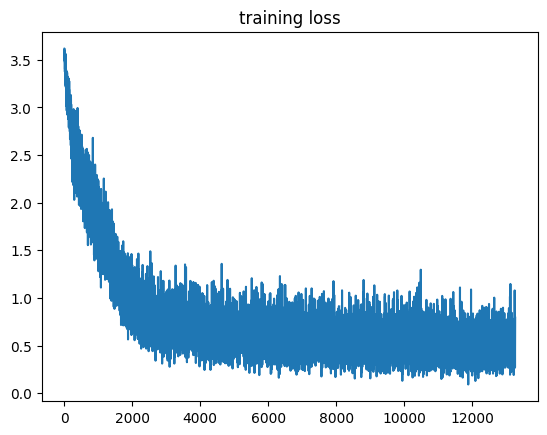

In [38]:
plt.plot(train_losses)
plt.title("training loss")

Text(0.5, 1.0, 'test accuracy')

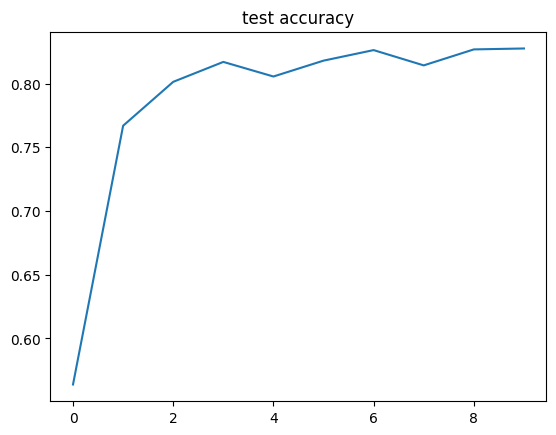

In [39]:
plt.plot(test_accuracy)
plt.title("test accuracy")

In [40]:
train_losses1 = train_losses
test_accuracy1 = test_accuracy

In [41]:
win_params1_list = model.conv1.window_params.detach().cpu().numpy()
win_params2_list = model.conv3.window_params.detach().cpu().numpy()
print(win_params1_list.shape)
print(win_params2_list.shape)

(128, 1, 2)
(128, 128, 3)


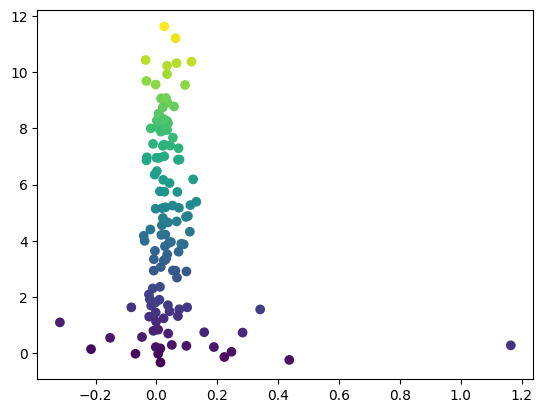

In [42]:
w1x = win_params1_list[..., 0].flatten()
w1y = win_params1_list[..., 1].flatten()
w1c = w1x + w1y
plt.scatter(w1x, w1y, c=w1c)

In [43]:
from mpl_toolkits import mplot3d

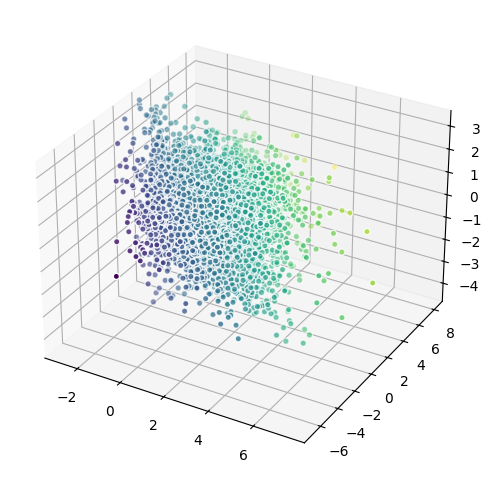

In [44]:
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection ='3d')

w2x = win_params2_list[...,0].flatten()
w2y = win_params2_list[...,1].flatten()
w2z = win_params2_list[...,2].flatten()
w2c = w2x + w2y
ax.set_xlim([w2x.min() - 0.1, w2x.max() + 0.1])
ax.set_ylim([w2y.min() - 0.1, w2y.max() + 0.1])
ax.set_zlim([w2z.min() - 0.1, w2z.max() + 0.1])
ax.scatter(w2x, w2y, w2z, c=w2c, edgecolor='white')

In [45]:
lowcut_bands1_m2 = model.conv1.lowcut_bands.detach().cpu().numpy()
bandwidths1_m2 = model.conv1.bandwidths.detach().cpu().numpy()
lowcut_bands2_m2 = model.conv3.lowcut_bands.detach().cpu().numpy()
bandwidths2_m2 = model.conv3.bandwidths.detach().cpu().numpy()

(array([2048., 3456., 3328., 2432., 2176., 1280.,  640.,  512.,  256.,
         256.]),
 array([0.0035846 , 0.0073439 , 0.01110321, 0.01486251, 0.01862181,
        0.02238112, 0.02614042, 0.02989972, 0.03365903, 0.03741833,
        0.04117763]),
 <BarContainer object of 10 artists>)

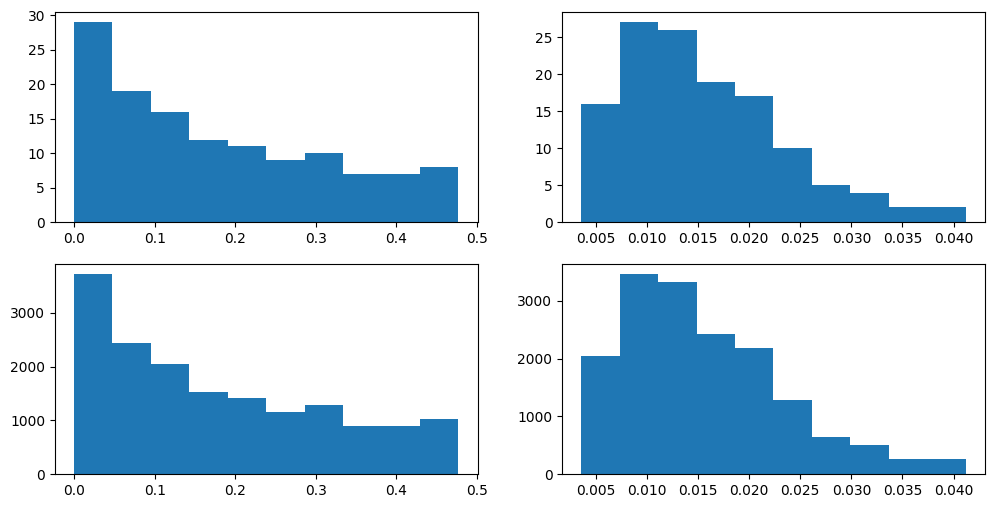

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
axes[0,0].hist(lowcut_bands1_m2.flatten())
axes[0,1].hist(bandwidths1_m2.flatten())
axes[1,0].hist(lowcut_bands2_m2.flatten())
axes[1,1].hist(bandwidths2_m2.flatten())

In [50]:
import numpy as np
import pandas as pd

/tmp/ipykernel_101970/1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [51]:
y_n_bin = 5
y_bins = np.linspace(0.,lowcut_bands1_m2.max(), y_n_bin+1)
x_n_bin = 3
x_bins = np.linspace(0.,bandwidths1_m2.max(), x_n_bin+1)

df = pd.DataFrame(data={
    'lowcut': lowcut_bands1_m2.flatten(), 
    'bandwidth': bandwidths1_m2.flatten(), 
    'window_params': list(rearrange(win_params1_list, 'h c p -> (h c) p')) 
})
df

,lowcut,bandwidth,window_params
0,0.000000,0.003585,"[1.1639469, 0.27501765]"
1,0.003585,0.003878,"[0.18867521, 0.21547994]"
2,0.007463,0.004196,"[-0.1522468, 0.54292595]"
3,0.011659,0.004540,"[-0.02381043, 1.295085]"
4,0.016199,0.004912,"[0.043152545, 1.4873835]"
...,...,...,...
123,0.389959,0.020805,"[0.026049925, 8.315996]"
124,0.410764,0.021390,"[0.11154497, 5.2678986]"
125,0.432154,0.021991,"[-0.035261117, 10.4313]"
126,0.454145,0.022610,"[-0.032975793, 9.685932]"


In [52]:
import math
import seaborn as sns
sns.set_theme(style="dark")

In [53]:
win_length = 17
df['lowcut_bin'] = df['lowcut'].apply(lambda x: 
                   max(math.ceil(x/lowcut_bands1_m2.max()*y_n_bin)-1, 0))
df['bandwidth_bin'] = df['bandwidth'].apply(lambda x: 
                   max(math.ceil(x/bandwidths1_m2.max()*x_n_bin)-1, 0))
df['window'] = df['window_params'].apply(lambda x:
                   general_cosine_window(win_length, x).numpy().flatten())
df['order'] = df.apply(
    lambda x: (y_n_bin -1 - x['lowcut_bin'])*x_n_bin + x['bandwidth_bin'], 
    axis=1)

In [54]:
df['order'].value_counts()

order
12    48
7     20
9     14
10    14
4     13
1      8
2      7
5      4
Name: count, dtype: int64

In [55]:
from einops import repeat

In [56]:
lowcut_bands1_m2.shape

(128, 1)

In [57]:
h, c = lowcut_bands1_m2.shape
df_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=win_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=win_length),  
    'window': np.hstack(df['window'].values),
    'window_t': repeat(np.arange(win_length), 'k -> (h c k)', h=h, c=c, k=win_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length),
    'order': repeat(df['order'].values, '(h c) -> (h c k)', h=h, c=c, k=win_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=win_length)
})
df_expanded

,lowcut,bandwidth,window,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,0.888929,0,0,0,12,0
1,0.000000,0.003585,0.909864,1,0,0,12,0
2,0.000000,0.003585,0.969480,2,0,0,12,0
3,0.000000,0.003585,1.058702,3,0,0,12,0
4,0.000000,0.003585,1.163947,4,0,0,12,0
...,...,...,...,...,...,...,...,...
2171,0.476755,0.023245,0.038485,12,4,1,1,127
2172,0.476755,0.023245,-0.227895,13,4,1,1,127
2173,0.476755,0.023245,-0.453720,14,4,1,1,127
2174,0.476755,0.023245,-0.604612,15,4,1,1,127


In [58]:
df_expanded['window_t'].describe()

count    2176.000000
mean        8.000000
std         4.900106
min         0.000000
25%         4.000000
50%         8.000000
75%        12.000000
max        16.000000
Name: window_t, dtype: float64

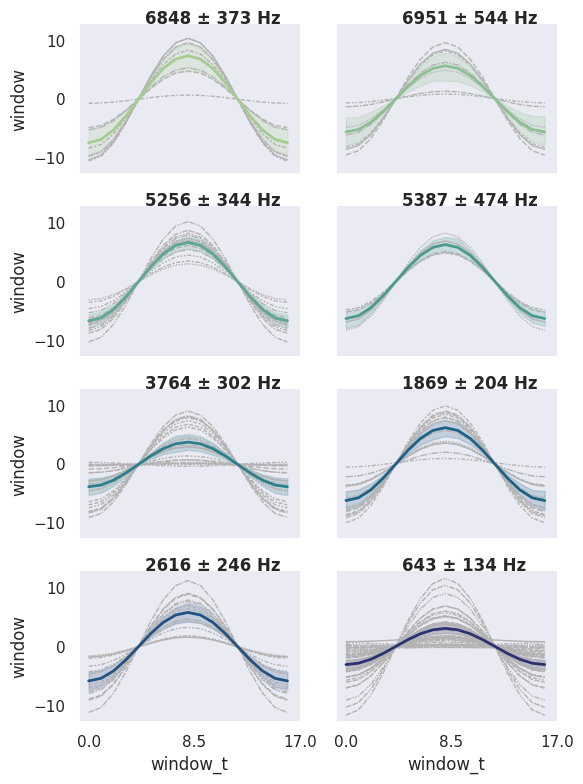

In [59]:
g = sns.relplot(
    data=df_expanded,
    x="window_t", 
    y='window', 
    col="order", hue="order",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = df_expanded[df_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.3, 1, subtitle, transform=ax.transAxes, fontweight="bold")

    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )
    
ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.tight_layout()

In [60]:
from IConNet.signal import get_window_freq_response

[ 0.00000000e+00 -5.27058071e-02 -2.11205151e-01 -4.76659184e-01
 -8.51055920e-01 -1.33729479e+00 -1.93931687e+00 -2.66229522e+00
 -3.51290849e+00 -4.49973525e+00 -5.63383007e+00 -6.92958571e+00
 -8.40606515e+00 -1.00891466e+01 -1.20151631e+01 -1.42375022e+01
 -1.68396645e+01 -1.99643366e+01 -2.38902362e+01 -2.93005519e+01
 -3.89782203e+01 -4.49406926e+01 -3.53460741e+01 -3.24789671e+01
 -3.15292086e+01 -3.16474180e+01 -3.25739960e+01 -3.42685052e+01
 -3.68636788e+01 -4.08035446e+01 -4.76829432e+01 -7.20154134e+01
 -4.84522389e+01 -4.39803253e+01 -4.20991555e+01 -4.14945461e+01
 -4.17867830e+01 -4.28747530e+01 -4.48284587e+01 -4.79579203e+01
 -5.32763101e+01 -6.77276609e+01 -5.89094487e+01 -5.25298907e+01
 -4.98539850e+01 -4.87076746e+01 -4.85469947e+01 -4.92049660e+01
 -5.06976993e+01 -5.32394545e+01 -5.75108930e+01 -6.66305559e+01
 -6.93195819e+01 -5.97533670e+01 -5.62035092e+01 -5.45475166e+01
 -5.39924257e+01 -5.42901605e+01 -5.54047727e+01 -5.74768372e+01
 -6.09784398e+01 -6.76680

<Axes: >

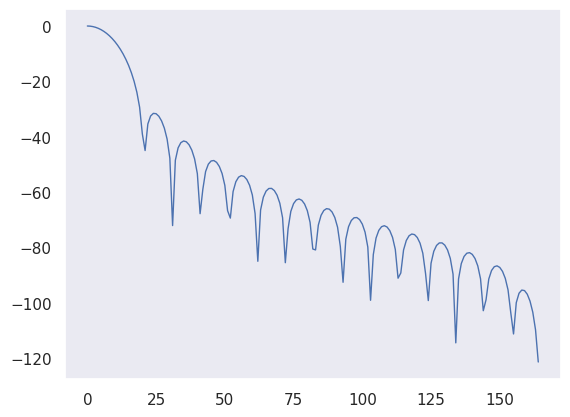

In [61]:
testresponse = get_window_freq_response(general_cosine_window(33,[0.5,0.5]))
tt = (testresponse.shape[-1]//2)
test_plt = testresponse[:tt]
print(test_plt)
sns.lineplot(test_plt, linewidth=1)

In [62]:
full_window_response_length = win_length*10
window_response_length = full_window_response_length
df['window_response'] = df['window'].apply(lambda x:
                   get_window_freq_response(x)[:window_response_length])

In [63]:
freq = np.fft.fftfreq(full_window_response_length,d=1/2)[:window_response_length]

In [64]:
h, c = lowcut_bands1_m2.shape
dff_expanded = pd.DataFrame(data={
    'lowcut': repeat(lowcut_bands1_m2, 'h c -> (h c k)', k=window_response_length), 
    'bandwidth': repeat(bandwidths1_m2, 'h c -> (h c k)', k=window_response_length),  
    'window_response': np.hstack(df['window_response'].values),
    'window_t': repeat(freq, 
                       'k -> (h c k)', h=h, c=c, k=window_response_length),
    'lowcut_bin': repeat(df['lowcut_bin'].values, 
                         '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'bandwidth_bin': repeat(df['bandwidth_bin'].values, 
                            '(h c) -> (h c k)', h=h, c=c, k=window_response_length),
    'order': repeat(df['order'].values, 
                    '(h c) -> (h c k)', h=h, c=c, k=window_response_length), 
    'win_id': repeat(np.arange(h*c), '(h c)-> (h c k)', h=h, c=c, k=window_response_length)
})
dff_expanded

,lowcut,bandwidth,window_response,window_t,lowcut_bin,bandwidth_bin,order,win_id
0,0.000000,0.003585,-9.643275e-16,0.000000,0,0,12,0
1,0.000000,0.003585,-1.217471e-01,0.011765,0,0,12,0
2,0.000000,0.003585,-4.904743e-01,0.023529,0,0,12,0
3,0.000000,0.003585,-1.117144e+00,0.035294,0,0,12,0
4,0.000000,0.003585,-2.021882e+00,0.047059,0,0,12,0
...,...,...,...,...,...,...,...,...
21755,0.476755,0.023245,-7.974091e+00,-0.058824,4,1,1,127
21756,0.476755,0.023245,-1.141559e+01,-0.047059,4,1,1,127
21757,0.476755,0.023245,-1.617734e+01,-0.035294,4,1,1,127
21758,0.476755,0.023245,-2.339717e+01,-0.023529,4,1,1,127


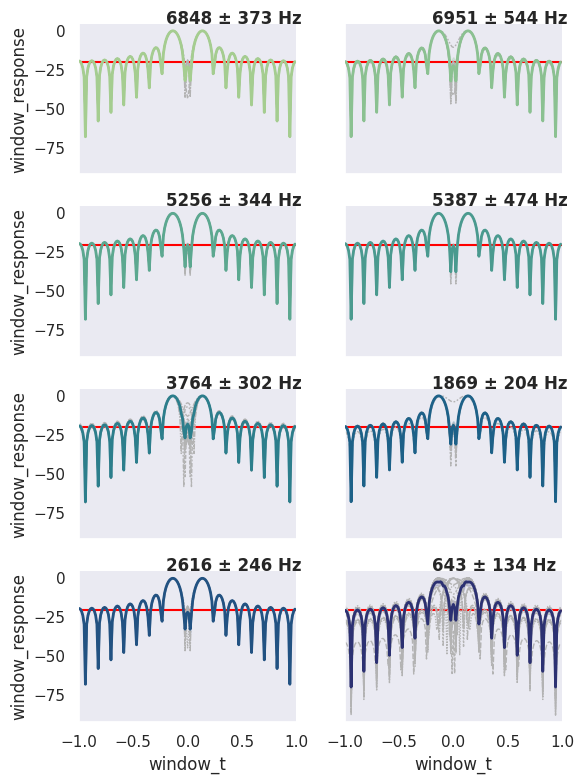

In [65]:
# sns.set(rc={'figure.figsize':(20,16)})
g = sns.relplot(
    data=dff_expanded,
    x="window_t", 
    y='window_response', 
    col="order", hue="order",
    # row='lowcut_bin', col='bandwidth_bin',
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=2, 
    height=2, aspect=1.5, legend=False,
)

for order, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    sub_df = dff_expanded[dff_expanded['order']==order]
    subtitle = f"{int(sub_df['lowcut'].mean()*16000)} ± {int(sub_df['bandwidth'].mean()*16000)} Hz"
    ax.text(.4, 1, subtitle, transform=ax.transAxes, fontweight="bold")
    ax.axhline(-20, color='red', zorder=1)
    
    # Plot every window in the background
    sns.lineplot(
        data=sub_df, 
        x="window_t", 
        y="window_response", 
        units="order",
        estimator=None, color=".7", linewidth=1, ax=ax, 
        style="win_id", legend=False
    )

    
    
# ax.set_xticks(np.linspace(0, win_length,3))
g.set_titles("")
g.set(xlim=[-1,1])
g.tight_layout()

In [ ]:
n_epoch = 10
n_epoch2 = 990
optimizer = optim.RAdam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(n_epoch+1, n_epoch + 1+n_epoch2):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                    | 0.0026702269692923898/990 [00:00<24:59:18, 90.87s/it]

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.712847


  0%|                     | 0.029372496662216304/990 [00:02<23:36:49, 85.87s/it]

Train Epoch: 11 [2560/84843 (3%)]	Loss: 0.229990


  0%|                      | 0.05607476635514024/990 [00:04<23:33:30, 85.67s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.369144


  0%|                      | 0.08277703604806397/990 [00:07<25:36:47, 93.15s/it]

Train Epoch: 11 [7680/84843 (9%)]	Loss: 0.211309


  0%|                      | 0.10947930574098763/990 [00:09<23:42:13, 86.21s/it]

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.350321


  0%|                      | 0.13618157543391152/990 [00:11<23:27:20, 85.30s/it]

Train Epoch: 11 [12800/84843 (15%)]	Loss: 0.222604


  0%|                      | 0.16288384512683574/990 [00:14<24:27:09, 88.93s/it]

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.352663


  0%|                      | 0.18958611481975995/990 [00:16<23:52:24, 86.83s/it]

Train Epoch: 11 [17920/84843 (21%)]	Loss: 0.350639


  0%|                      | 0.21628838451268417/990 [00:19<25:10:35, 91.57s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.335095


  0%|                       | 0.2429906542056084/990 [00:21<23:43:26, 86.29s/it]

Train Epoch: 11 [23040/84843 (27%)]	Loss: 0.390535


  0%|                       | 0.2696929238985326/990 [00:23<24:06:08, 87.67s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.283458


  0%|                      | 0.29639519359145683/990 [00:26<24:53:03, 90.52s/it]

Train Epoch: 11 [28160/84843 (33%)]	Loss: 0.327755


  0%|                      | 0.32309746328438105/990 [00:28<26:29:26, 96.36s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.271415


  0%|                     | 0.34979973297730527/990 [00:31<27:35:07, 100.35s/it]

Train Epoch: 11 [33280/84843 (39%)]	Loss: 0.377547


  0%|                       | 0.3765020026702295/990 [00:34<26:12:21, 95.33s/it]

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.201193


  0%|                       | 0.4032042723631537/990 [00:36<25:39:15, 93.33s/it]

Train Epoch: 11 [38400/84843 (45%)]	Loss: 0.251226


  0%|                       | 0.4299065420560779/990 [00:38<24:58:12, 90.84s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.634089


  0%|                      | 0.45660881174900214/990 [00:41<24:33:05, 89.32s/it]

Train Epoch: 11 [43520/84843 (51%)]	Loss: 0.260915


  0%|                     | 0.48331108144192636/990 [00:43<27:34:29, 100.32s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.236128


  0%|                       | 0.5100133511348506/990 [00:46<24:02:54, 87.49s/it]

Train Epoch: 11 [48640/84843 (57%)]	Loss: 0.317358


  0%|                       | 0.5367156208277748/990 [00:48<24:30:31, 89.17s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.429676


  0%|                        | 0.563417890520699/990 [00:50<23:41:38, 86.21s/it]

Train Epoch: 11 [53760/84843 (63%)]	Loss: 0.530156


  0%|                       | 0.5901201602136232/990 [00:53<23:35:32, 85.84s/it]

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.655289


  0%|                       | 0.6168224299065475/990 [00:55<23:56:15, 87.10s/it]

Train Epoch: 11 [58880/84843 (69%)]	Loss: 0.257588


  0%|                       | 0.6435246995994717/990 [00:57<23:33:38, 85.73s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.272996


  0%|                       | 0.6702269692923959/990 [01:00<24:26:53, 88.96s/it]

Train Epoch: 11 [64000/84843 (75%)]	Loss: 0.181227


  0%|                       | 0.6969292389853201/990 [01:02<23:38:42, 86.04s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.163346


  0%|                       | 0.7236315086782443/990 [01:04<24:23:43, 88.78s/it]

Train Epoch: 11 [69120/84843 (81%)]	Loss: 0.346186


  0%|                       | 0.7503337783711685/990 [01:07<23:48:05, 86.62s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.518356


  0%|                       | 0.7770360480640928/990 [01:09<23:55:30, 87.07s/it]

Train Epoch: 11 [74240/84843 (87%)]	Loss: 0.160667


  0%|                        | 0.803738317757017/990 [01:12<23:47:19, 86.57s/it]

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.261692


  0%|                       | 0.8304405874499412/990 [01:14<24:00:16, 87.36s/it]

Train Epoch: 11 [79360/84843 (94%)]	Loss: 0.330225


  0%|                       | 0.8571428571428654/990 [01:16<23:52:03, 86.87s/it]

Train Epoch: 11 [81920/84843 (97%)]	Loss: 0.398659


  0%|                       | 0.8838451268357896/990 [01:19<24:44:44, 90.07s/it]

Train Epoch: 11 [84480/84843 (100%)]	Loss: 0.413154


  0%|                       | 1.0020026702269793/990 [01:24<12:56:12, 47.09s/it]


Test Epoch: 11	Accuracy: 9400/11005 (85%)

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.564296


  0%|                       | 1.0293724966622266/990 [01:26<23:27:20, 85.38s/it]

Train Epoch: 12 [2560/84843 (3%)]	Loss: 0.192892


  0%|                       | 1.0560747663551509/990 [01:29<24:26:14, 88.96s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.422457


  0%|                        | 1.082777036048075/990 [01:31<24:17:28, 88.43s/it]

Train Epoch: 12 [7680/84843 (9%)]	Loss: 0.369370


  0%|                       | 1.1094793057409993/990 [01:33<24:06:58, 87.79s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.365060


  0%|                      | 1.1361815754339235/990 [01:36<29:31:18, 107.48s/it]

Train Epoch: 12 [12800/84843 (15%)]	Loss: 0.344429


  0%|                       | 1.1628838451268477/990 [01:38<27:05:08, 98.61s/it]

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.323318


  0%|                        | 1.189586114819772/990 [01:41<26:06:02, 95.03s/it]

Train Epoch: 12 [17920/84843 (21%)]	Loss: 0.354226


  0%|                       | 1.2162883845126962/990 [01:44<25:25:22, 92.56s/it]

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.629834


  0%|                       | 1.2429906542056204/990 [01:46<24:17:11, 88.43s/it]

Train Epoch: 12 [23040/84843 (27%)]	Loss: 0.276723


  0%|                       | 1.2696929238985446/990 [01:48<24:27:24, 89.05s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.310895


  0%|                       | 1.2963951935914688/990 [01:51<24:27:45, 89.07s/it]

Train Epoch: 12 [28160/84843 (33%)]	Loss: 0.349516


  0%|                        | 1.323097463284393/990 [01:53<23:53:45, 87.01s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.140856


  0%|                       | 1.3497997329773173/990 [01:56<25:20:23, 92.27s/it]

Train Epoch: 12 [33280/84843 (39%)]	Loss: 0.337350


  0%|                       | 1.3765020026702415/990 [01:58<25:14:38, 91.92s/it]

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.171303


  0%|                       | 1.4032042723631657/990 [02:00<25:00:15, 91.05s/it]

Train Epoch: 12 [38400/84843 (45%)]	Loss: 0.393350


  0%|                         | 1.42990654205609/990 [02:03<24:22:34, 88.77s/it]

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.421394


  0%|                       | 1.4566088117490141/990 [02:05<23:59:04, 87.35s/it]

Train Epoch: 12 [43520/84843 (51%)]	Loss: 0.282119


  0%|                       | 1.4833110814419384/990 [02:08<24:00:20, 87.42s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.449081


  0%|                       | 1.5100133511348626/990 [02:10<23:41:52, 86.31s/it]

Train Epoch: 12 [48640/84843 (57%)]	Loss: 0.271585


  0%|                       | 1.5367156208277868/990 [02:12<23:42:01, 86.32s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.267877


  0%|                        | 1.563417890520711/990 [02:15<23:42:48, 86.37s/it]

Train Epoch: 12 [53760/84843 (63%)]	Loss: 0.433692


  0%|                       | 1.5901201602136352/990 [02:17<24:05:21, 87.74s/it]

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.180508


  0%|                       | 1.6168224299065594/990 [02:19<26:04:27, 94.97s/it]

Train Epoch: 12 [58880/84843 (69%)]	Loss: 0.265354


  0%|                       | 1.6435246995994837/990 [02:22<24:23:54, 88.87s/it]

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.252770


  0%|                       | 1.6702269692924079/990 [02:24<25:09:41, 91.65s/it]

Train Epoch: 12 [64000/84843 (75%)]	Loss: 0.399758


  0%|                        | 1.696929238985332/990 [02:27<24:41:08, 89.92s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.397484


  0%|                       | 1.6995994659546245/990 [02:27<24:27:34, 89.10s/it]

In [ ]:
model_path = "../M9_multi_firwin_sc_1000epochs.pt"
torch.save(model.state_dict(), model_path)

In [ ]:
plt.plot(train_losses)
plt.title("training loss")

In [ ]:
plt.plot(test_accuracy)
plt.title("test accuracy")